In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

# 自定义模块
from TransformerModel import TimeSeriesTransformer
from LSTMModel import TimeSeriesLSTM
from Blender import MLPBlender
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves, grid_search, safe_inverse_transform, split_time_series

# 其他库
from torch.utils.data import random_split, TensorDataset
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# 准备数据
df_complete = pd.read_csv ('../TockFormerData\SPY_2020-01-01_2025-05-03_60m.csv')

# 先把数据分成3份再create sequence，这样scale才不会泄漏
df_train, df_val, df_test = split_time_series(df_complete, 0.8, 0.15, 0.05)

In [6]:
target_cols = ['open', 'high', 'low', 'close']
seq_length = 32

# 创建序列
X_train, y_train, scaler, target_indices = create_sequences(df_train, seq_length=seq_length, target_cols=target_cols, scale=True)
X_val, y_val, _, _ = create_sequences(df_val, seq_length=seq_length, target_cols=target_cols, scaler=scaler)
X_test, y_test, _, _ = create_sequences(df_test, seq_length=seq_length, target_cols=target_cols, scaler=scaler)

数据被缩放
数据被缩放
数据被缩放


In [7]:
train_dataset = TensorDataset(X_train, y_train)
sample_dataset = sample_dataset(train_dataset, 0.1)  # 采样10%的数据用于超参数
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Sample dataset size: {len(sample_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")
print (f"Val dataset size: {len(val_dataset)}")

Train dataset size: 17052
Sample dataset size: 1705
Test dataset size: 1036
Val dataset size: 3171


In [ ]:
# 定义网格搜索 时序Transformer，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    sample_dataset,
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

In [9]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_tock = {
 'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 48,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1
 }


best_params_tock

{'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 48,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 334. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 420. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 470. Reshuffling training data.
Epoch 1/50, Train Loss: 0.009584
Epoch 1/50, Val MSEs: [5060.62451171875, 3965.82080078125, 6092.10595703125, 4174.6689453125], R²: [-4.589435577392578, -3.3922901153564453, -5.708529949188232, -3.609358787536621]
Epoch 2: Bad batch threshold reached at batch 214. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 373. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 423. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 495. Reshuffling training data.
Epoch 2/50, Train Loss: 0.001839
Epoch 2/50, Val MSEs: [3216.489990234375, 3243.614990234375, 3997.115966796875, 2545.668701171875], R²: [-2.5525975227355957, -2.592420816421509, -3.4015607833862305, -1.8107378482818604]


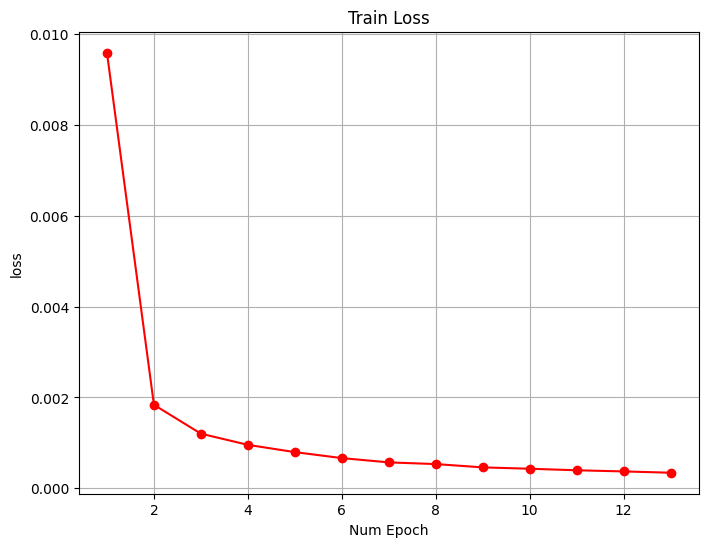

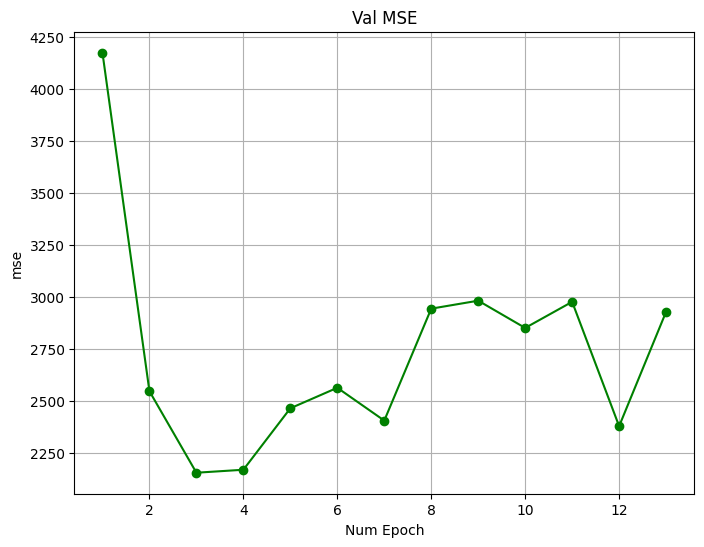

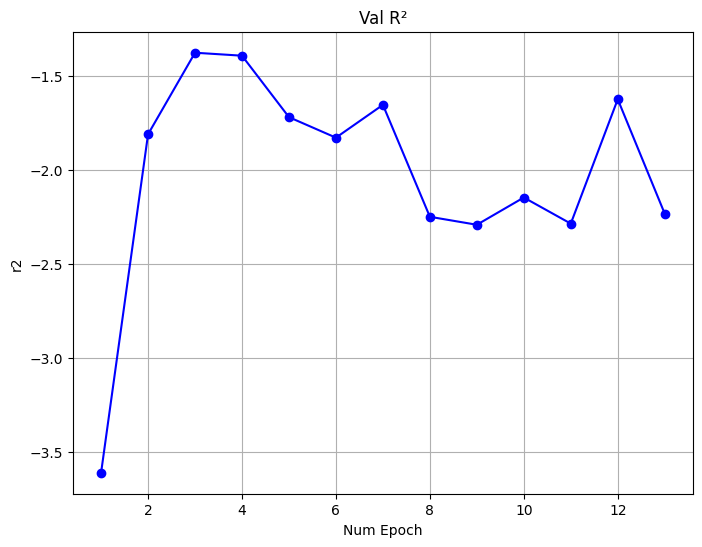

In [10]:
# 如果表现优异，对 tock 进行 train
tock = TimeSeriesTransformer (**best_params_tock)
train_loss, mse_list_train, r2_list_train = tock.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [3534.344482421875, 4312.54150390625, 4957.28515625, 2790.903564453125]
测试集 R²:  [-2.898794412612915, -3.953129768371582, -4.256767272949219, -2.0818638801574707]


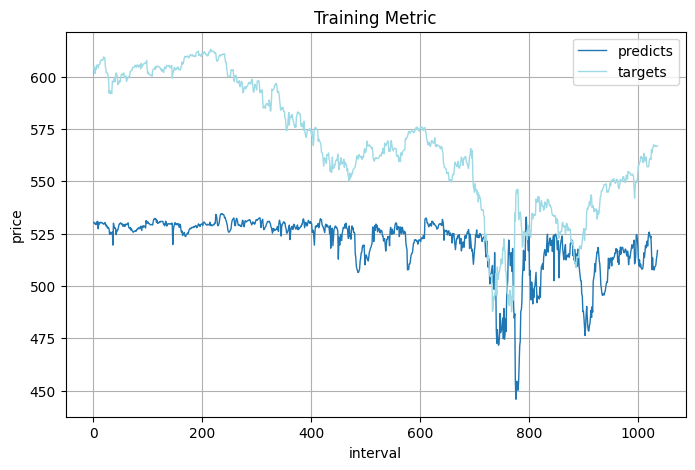

In [13]:
# 对test 进行测试
mse_list_tock, r2_list_tock, preds_tock, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_tock)
print ("测试集 R²: ", r2_list_tock)

curve_dict = {}
curve_dict['predicts'] = preds_tock[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 网格搜索 LSTM 超参数

init_args_lstm = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

param_grid_lstm = {
    'hidden_dim': [64, 128],
    'num_layers': [2, 3],
}

best_params_lstm, best_score_lstm = grid_search (
    TimeSeriesLSTM,
    init_args_lstm,
    sample_dataset,
    param_grid=param_grid_lstm,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params_lstm)
print ('Best avg CV MSE:', best_score_lstm)

In [11]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_lstm = {
 'hidden_dim': 64,
 'input_dim': 48,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1
 }

best_params_lstm

{'hidden_dim': 64,
 'input_dim': 48,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1}

Epoch 1: reshuffling after 289 bad batches
Epoch 1: reshuffling after 385 bad batches
Epoch 1: reshuffling after 464 bad batches
Epoch 1: reshuffling after 522 bad batches
Epoch 1/50, Loss: 0.043085
Epoch 1/50, Val MSEs: [2925.406494140625, 2906.0068359375, 2967.24658203125, 3027.064697265625], R²: [-2.2310972213745117, -2.218507766723633, -2.267484664916992, -2.342259407043457]
Epoch 2: reshuffling after 113 bad batches
Epoch 2: reshuffling after 192 bad batches
Epoch 2: reshuffling after 242 bad batches
Epoch 2: reshuffling after 292 bad batches
Epoch 2: reshuffling after 363 bad batches
Epoch 2: reshuffling after 458 bad batches
Epoch 2: reshuffling after 508 bad batches
Epoch 2/50, Loss: 0.000367
Epoch 2/50, Val MSEs: [2703.291015625, 2760.797607421875, 2759.781494140625, 2805.5390625], R²: [-1.985771894454956, -2.057682991027832, -2.039027452468872, -2.0976672172546387]
Epoch 3: reshuffling after 84 bad batches
Epoch 3: reshuffling after 134 bad batches
Epoch 3: reshuffling after 

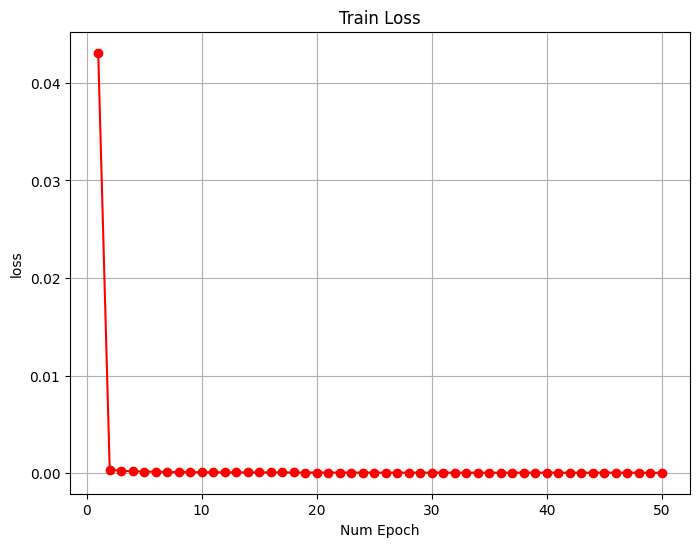

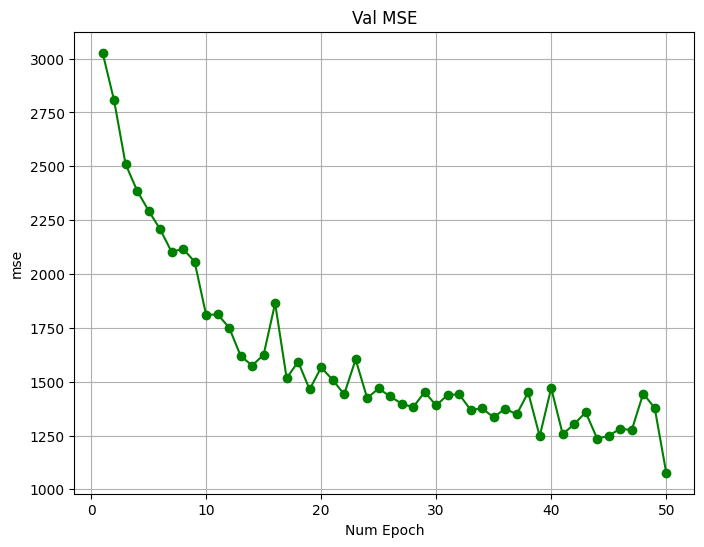

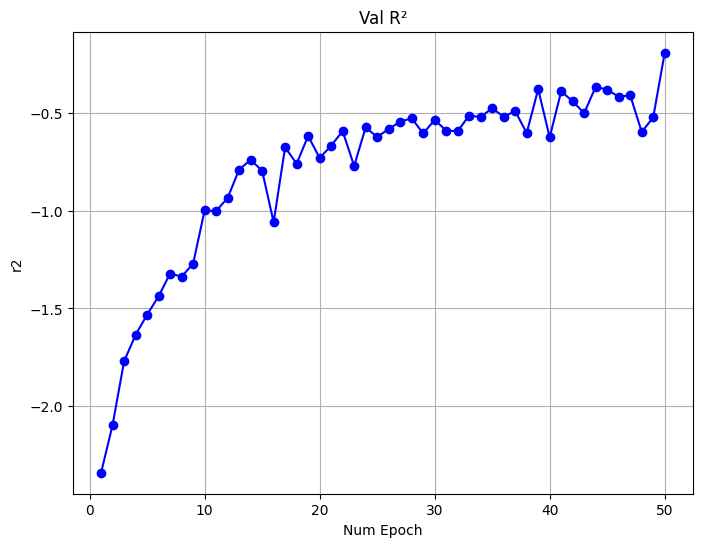

In [12]:
# 如果表现优异，对 lstm 进行 train
lstm = TimeSeriesLSTM (**best_params_lstm)
train_loss, mse_list_train, r2_list_train = lstm.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [1509.6541748046875, 1580.778076171875, 1463.3270263671875, 1505.48876953125]
测试集 R²:  [-0.6653246879577637, -0.815588116645813, -0.5517302751541138, -0.6624406576156616]


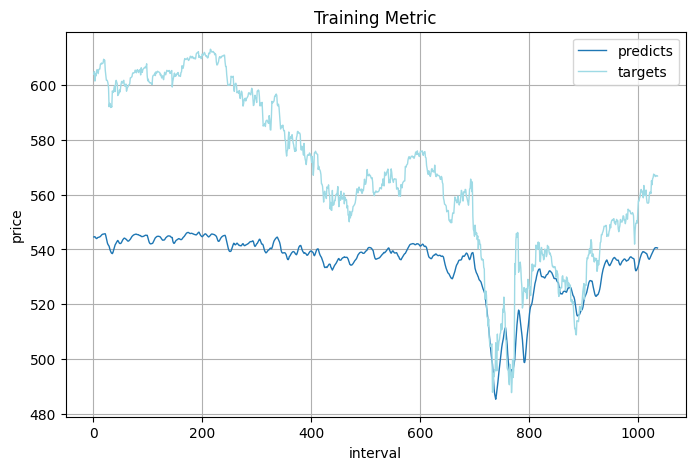

In [14]:
mse_list_lstm, r2_list_lstm, preds_lstm, targets = lstm.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_lstm)
print ("测试集 R²: ", r2_list_lstm)

curve_dict = {}
curve_dict['predicts'] = preds_lstm[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [15]:
# 定义 blender 训练参数
# 
# （使用自定义blender，而不是sklearn，base在train上训练， blender在 val上训练 即 base 对val 的预测， 最后整体在 test 上测试）


blender_params = {
    'base_models': [tock, lstm],  # 基础模型列表
    'output_dim': 4,  # 4个目标值
    'hidden_dims': [32, 16],
    'dropout': 0.1,
}

blender = MLPBlender (**blender_params)

blender.fit (val_dataset, num_epochs=50, batch_size=32, lr=1e-4, log=True)

[MLPBlender] Epoch 1/50 – Loss 1.420106
[MLPBlender] Epoch 2/50 – Loss 1.210597
[MLPBlender] Epoch 3/50 – Loss 0.813244
[MLPBlender] Epoch 4/50 – Loss 0.463495
[MLPBlender] Epoch 5/50 – Loss 0.260015
[MLPBlender] Epoch 6/50 – Loss 0.159645
[MLPBlender] Epoch 7/50 – Loss 0.114863
[MLPBlender] Epoch 8/50 – Loss 0.087972
[MLPBlender] Epoch 9/50 – Loss 0.076970
[MLPBlender] Epoch 10/50 – Loss 0.066378
[MLPBlender] Epoch 11/50 – Loss 0.063273
[MLPBlender] Epoch 12/50 – Loss 0.060603
[MLPBlender] Epoch 13/50 – Loss 0.060032
[MLPBlender] Epoch 14/50 – Loss 0.060119
[MLPBlender] Epoch 15/50 – Loss 0.060859
[MLPBlender] Epoch 16/50 – Loss 0.057482
[MLPBlender] Epoch 17/50 – Loss 0.058457
[MLPBlender] Epoch 18/50 – Loss 0.053998
[MLPBlender] Epoch 19/50 – Loss 0.052609
[MLPBlender] Epoch 20/50 – Loss 0.052911
[MLPBlender] Epoch 21/50 – Loss 0.051161
[MLPBlender] Epoch 22/50 – Loss 0.050674
[MLPBlender] Epoch 23/50 – Loss 0.051301
[MLPBlender] Epoch 24/50 – Loss 0.048192
[MLPBlender] Epoch 25/50 

In [16]:
weights = blender.get_model_importance ()
print ("Blender weights: ", weights)

Blender weights:  {'model_TimeSeriesTransformer': 0.5281327962875366, 'model_TimeSeriesLSTM': 0.4718672037124634}


In [ ]:
preds_blender = blender.predict (test_dataset, batch_size=32)
preds_blender = safe_inverse_transform (preds_blender, scaler, target_indices)
mse = [mean_squared_error(targets[:, i], preds_blender[:, i]) for i in range(preds_blender.shape[1])]
print ("Blender MSE: ", mse)
preds_blender[:3]

Blender MSE:  830.8757934570312


array([[554.41144, 557.69135, 560.9561 , 558.8096 ],
       [554.32886, 557.6179 , 560.88477, 558.75415],
       [554.41907, 557.7001 , 560.97723, 558.83154]], dtype=float32)

In [18]:
preds_lstm[:3]

array([[544.4825 , 544.4    , 544.234  , 544.5645 ],
       [544.51373, 544.4319 , 544.2656 , 544.5964 ],
       [544.5821 , 544.501  , 544.3345 , 544.6663 ]], dtype=float32)

In [19]:
preds_tock[:3]

array([[520.2645 , 513.1869 , 502.19757, 530.4303 ],
       [520.12195, 513.0354 , 502.5727 , 529.7535 ],
       [520.423  , 513.5024 , 502.05804, 529.95917]], dtype=float32)

In [ ]:
# 训练 residual module

from BiasCorrector import BiasCorrector
from sklearn.metrics import mean_squared_error, r2_score


x_tensor = val_dataset.tensors[0]  # 输入特征
y_tensor = val_dataset.tensors[1]  # 对应标签

y = tock.safe_inverse_transform(y_tensor.numpy(), scaler=scaler, target_indices=target_indices)

# 使用 base model 进行预测（注意需要 batch 预测，如果模型较大）
preds_val = tock.predict_model(x_tensor, scaler=scaler, bias_corrector=None, target_indices=target_indices)  # shape: (N, num_targets)


mlp_corrector = BiasCorrector(mode='mean', scale='None')
mlp_corrector.fit(preds_val, y)


In [ ]:
mse_list_cor, r2_list_cor, preds_cor, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices,
                                                                        bias_corrector=mlp_corrector)

print ("测试集 MSE: ", mse_list_cor)
print ("测试集 R²: ", r2_list_cor)

curve_dict = {}
curve_dict['predicts'] = preds_cor[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)